# Телекоммуникации. Выпускной проект

## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.  
**Цель проекта:** создать модель для прогноза оттока клиентов (задача классификации).

*Описание услуг*

Оператор предоставляет два основных типа услуг: 
* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).  

Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).  

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

*Описание данных*

Данные состоят из нескольких файлов, полученных из разных источников:

* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

Файл ``contract_new.csv``
* customerID — идентификатор абонента;
* BeginDate — дата начала действия договора;
* EndDate — дата окончания действия договора;
* Type — тип оплаты: раз в год-два или ежемесячно;
* PaperlessBilling — электронный расчётный лист;
* PaymentMethod — тип платежа;
* MonthlyCharges — расходы за месяц;
* TotalCharges — общие расходы абонента.

Файл ``personal_new.csv``
* customerID — идентификатор пользователя;
* gender — пол;
* SeniorCitizen — является ли абонент пенсионером;
* Partner — есть ли у абонента супруг или супруга;
* Dependents — есть ли у абонента дети.

Файл ``internet_new.csv``
* customerID — идентификатор пользователя;
* InternetService — тип подключения;
* OnlineSecurity — блокировка опасных сайтов;
* OnlineBackup — облачное хранилище файлов для резервного копирования данных;
* DeviceProtection — антивирус;
* TechSupport — выделенная линия технической поддержки;
* StreamingTV — стриминговое телевидение;
* StreamingMovies — каталог фильмов.

Файл ``phone_new.csv``
* customerID — идентификатор пользователя;
* MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

*План работы*

    Шаг 1. Загрузка данных, базовый осмотр данных, подготовка данных для работы
    Шаг 2. Объединение данных и предобработка объединённого датафрейма
    Шаг 3. Исследовательский и корреляционный анализ данных
    Шаг 4. Подготовка данных для обучения моделей
    Шаг 5. Обучение моделей машинного обучения
    Шаг 6. Выбор лучшей модели. Анализ признаков, матрица ошибок
    Шаг 7. Общий вывод и рекомендации заказчику

## Загрузка данных

In [1]:
!pip install -q phik
!pip install -q --upgrade scikit-learn
!pip install -q shap
!pip install -q matplotlib==3.5.0

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import phik
from phik.report import plot_correlation_matrix
import shap
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

In [3]:
contract_df = pd.read_csv('/datasets/contract_new.csv', parse_dates=['BeginDate'], index_col='customerID')
personal_df = pd.read_csv('/datasets/personal_new.csv', index_col='customerID')
internet_df = pd.read_csv('/datasets/internet_new.csv', index_col='customerID')
phone_df = pd.read_csv('/datasets/phone_new.csv', index_col='customerID')

In [4]:
contract_df.info()
contract_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Видим, что формат столбца ``TotalCharges`` - object, исправим это

In [5]:
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors='coerce')
contract_df[contract_df['TotalCharges'].isna()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN


Появились пустые строки у пользователей с датой начала договора равной дате выгрузки данных. Заменим на 0.

In [6]:
contract_df = contract_df.fillna(0)

In [7]:
contract_df.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [8]:
personal_df.info()
personal_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


Преобразуем тип данных столбца ``SeniorCitizen`` в object, так как это категориальный признак

In [9]:
personal_df['SeniorCitizen'] = personal_df['SeniorCitizen'].astype('object')

In [10]:
personal_df.info()
personal_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   object
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: object(4)
memory usage: 275.1+ KB


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [11]:
internet_df.info()
internet_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
phone_df.info()
phone_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


**Вывод**  
На этапе загрузки данных были импортированы необходимые библиотеки, проведен первичный осмотр данных. Обработаны пустые строки в ``contract_df``, приведен к соответствующему типу данных столбец 'SeniorCitizen' в ``personal_df``

## Объединение данных и предобработка

In [13]:
all_df = contract_df.join(personal_df)
all_df = all_df.join(internet_df)
all_df = all_df.join(phone_df)

In [14]:
all_df.info()
all_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBackup      5517 non-null   object        
 14  DeviceProtecti

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [15]:
all_df.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.312885
std,30.090047,2112.742814
min,18.250000,0.000000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


In [16]:
all_df.isna().mean().sort_values(ascending=False).round(3)*100 # процент пропусков

StreamingMovies     21.7
StreamingTV         21.7
TechSupport         21.7
DeviceProtection    21.7
OnlineBackup        21.7
OnlineSecurity      21.7
InternetService     21.7
MultipleLines        9.7
Dependents           0.0
BeginDate            0.0
EndDate              0.0
SeniorCitizen        0.0
gender               0.0
TotalCharges         0.0
MonthlyCharges       0.0
PaymentMethod        0.0
PaperlessBilling     0.0
Type                 0.0
Partner              0.0
dtype: float64

Пропущенные значения есть у пользователей, которые не подключали интернет услуги, заполним пропуски значением ``No package``

In [17]:
col_missing_values = ['StreamingMovies', 'StreamingTV', 'TechSupport', 'DeviceProtection', 'OnlineBackup', 'OnlineSecurity', 'InternetService', 'MultipleLines']
all_df[col_missing_values] = all_df[col_missing_values].fillna('No package')

In [18]:
all_df.isna().mean().sort_values(ascending=False).round(3)*100

BeginDate           0.0
Dependents          0.0
StreamingMovies     0.0
StreamingTV         0.0
TechSupport         0.0
DeviceProtection    0.0
OnlineBackup        0.0
OnlineSecurity      0.0
InternetService     0.0
Partner             0.0
EndDate             0.0
SeniorCitizen       0.0
gender              0.0
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
PaperlessBilling    0.0
Type                0.0
MultipleLines       0.0
dtype: float64

In [19]:
all_df.info()
all_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No package
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No package
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Объединенная таблица готова, теперь создадим новые признаки - продолжительность действия договора в днях (за конечную дату актуальных договоров возьмем дату выгрузки 2020-02-01) и добавим целевой признак

In [20]:
all_df['status'] = all_df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

In [21]:
all_df['EndDate'] = all_df['EndDate'].replace('No', '2020-02-01')
all_df['EndDate'] = pd.to_datetime(all_df['EndDate'])
all_df['contract_term'] = (all_df['EndDate'] - all_df['BeginDate']).dt.days
all_df.loc[all_df['status'] == 0, 'EndDate'] = 'No'

In [22]:
all_df.info()
all_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,status,contract_term
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,No package,0,31
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,DSL,Yes,Yes,No,No,No,No,No,0,123
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,DSL,Yes,No,Yes,Yes,No,No,No package,0,1371
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,Fiber optic,No,No,No,No,No,No,No,0,153


**Вывод**  
На данном подготовительном этапе объединили все таблицы в одну ``all_df``. Обработали пропущенные значения в полученном объединенном датафрейме. Создали новый признак - срок договора в днях. Извлекли из столбца 'EndDate' целевой признак 'status'.

## Исследовательский анализ данных

Для дальнейшего анализа столобцы с датами не нужны, удалим их

In [23]:
all_df = all_df.drop(['BeginDate', 'EndDate'], axis=1)

### Количественные признаки

In [24]:
all_df.drop('status', axis=1).describe()

,MonthlyCharges,TotalCharges,contract_term
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,898.555729
std,30.090047,2112.742814,683.130510
min,18.250000,0.000000,0.000000
25%,35.500000,436.750000,276.000000
50%,70.350000,1343.350000,761.000000
75%,89.850000,3236.690000,1461.000000
max,118.750000,9221.380000,2314.000000


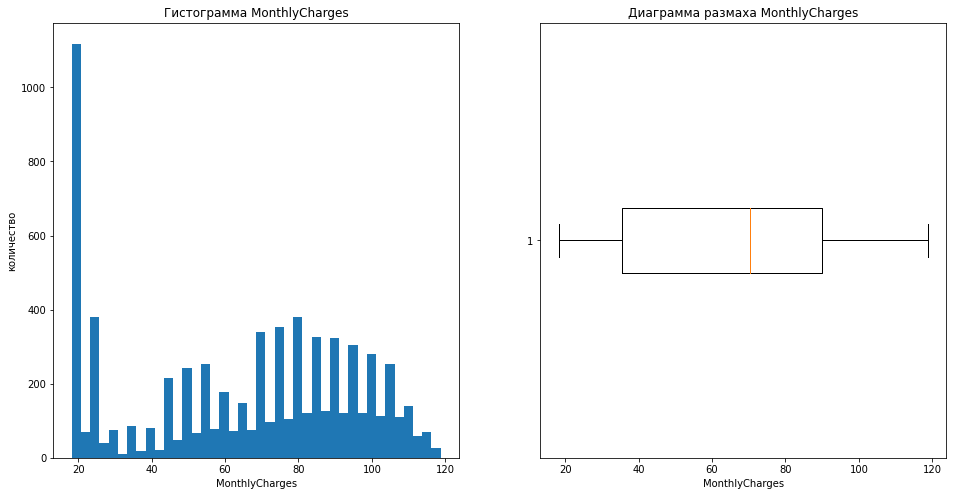

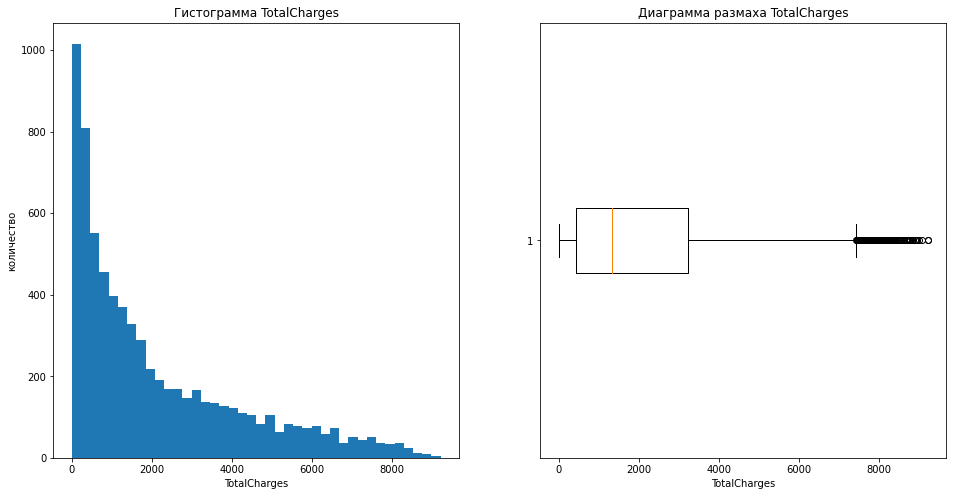

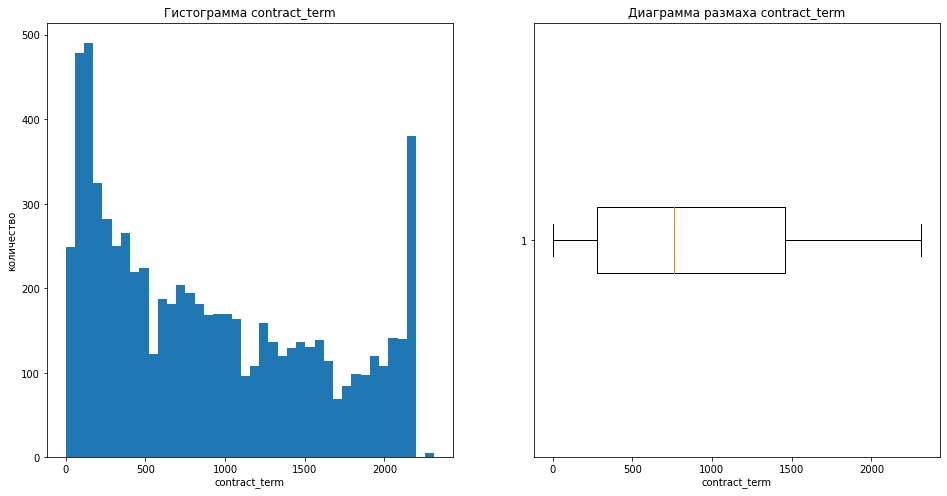

In [25]:
for col in all_df.select_dtypes(exclude='object').drop('status', axis=1).columns:
    fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
    ax[0].hist(data=all_df, x=col, bins=40)
    ax[0].set_title(f'Гистограмма {col}')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('количество')
    ax[1].boxplot(data=all_df, x=col, vert=False)
    ax[1].set_title(f'Диаграмма размаха {col}')
    ax[1].set_xlabel(col)
    plt.show()

### Категориальные признаки

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

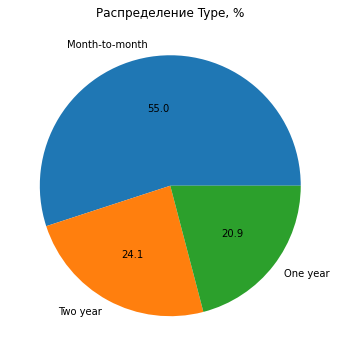

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

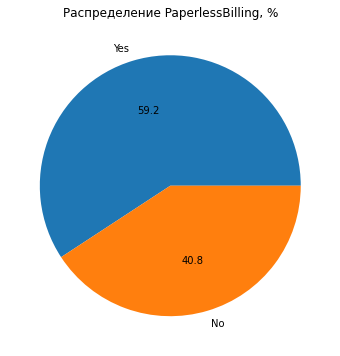

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

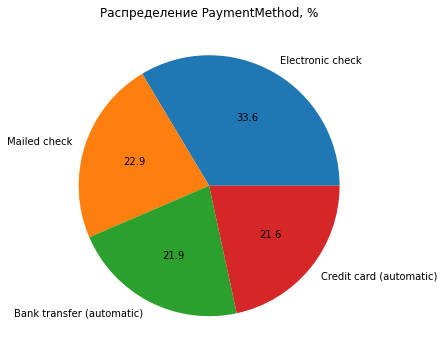

Male      3555
Female    3488
Name: gender, dtype: int64

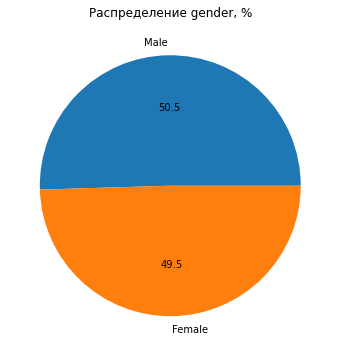

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

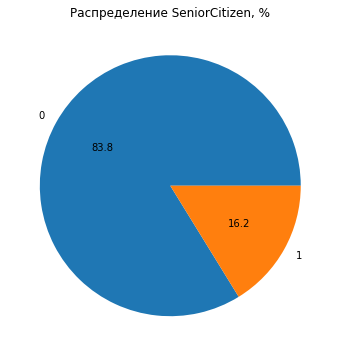

No     3641
Yes    3402
Name: Partner, dtype: int64

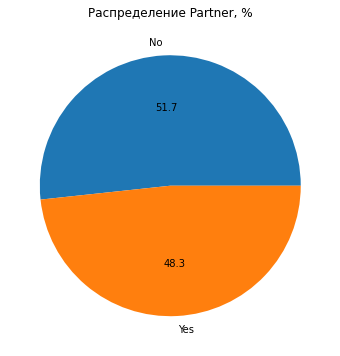

No     4933
Yes    2110
Name: Dependents, dtype: int64

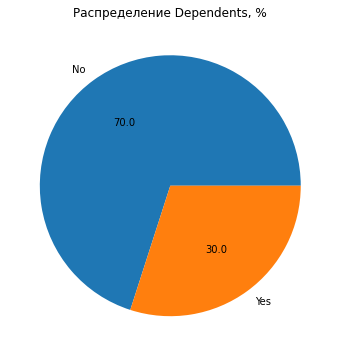

Fiber optic    3096
DSL            2421
No package     1526
Name: InternetService, dtype: int64

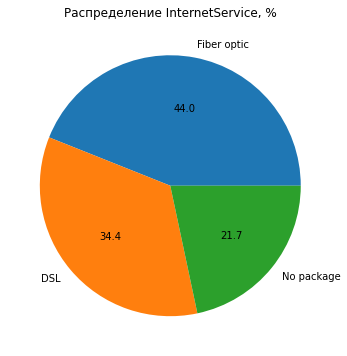

No            3498
Yes           2019
No package    1526
Name: OnlineSecurity, dtype: int64

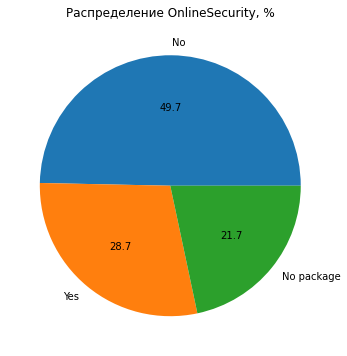

No            3088
Yes           2429
No package    1526
Name: OnlineBackup, dtype: int64

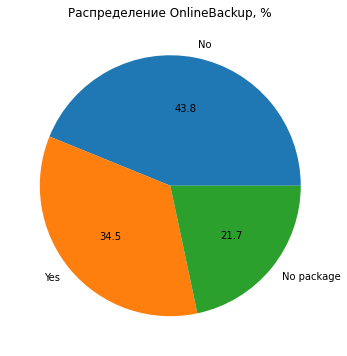

No            3095
Yes           2422
No package    1526
Name: DeviceProtection, dtype: int64

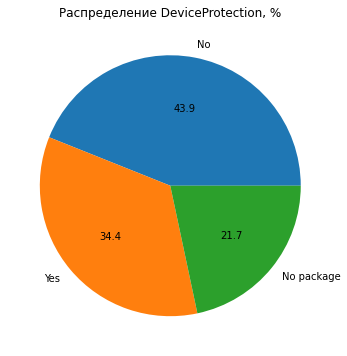

No            3473
Yes           2044
No package    1526
Name: TechSupport, dtype: int64

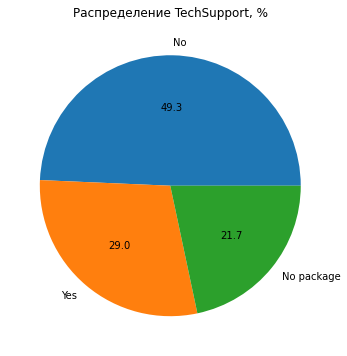

No            2810
Yes           2707
No package    1526
Name: StreamingTV, dtype: int64

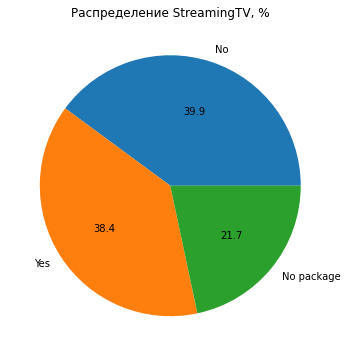

No            2785
Yes           2732
No package    1526
Name: StreamingMovies, dtype: int64

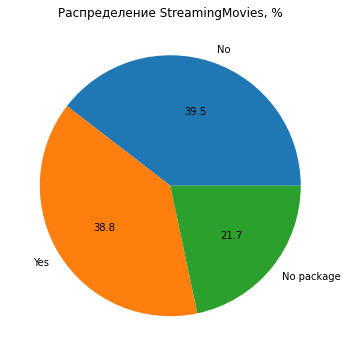

No            3390
Yes           2971
No package     682
Name: MultipleLines, dtype: int64

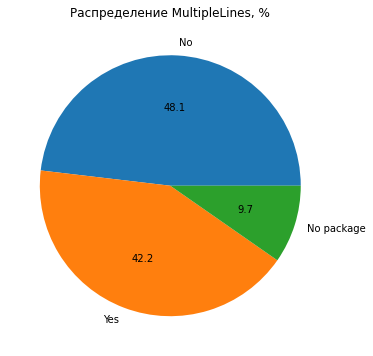

In [26]:
for col in all_df.select_dtypes('object').columns:
    display(all_df[col].value_counts())
    all_df[col].value_counts().plot(kind='pie', title=f'Распределение {col}, %', autopct='%.1f', figsize=(10, 6))
    plt.ylabel(None)
    plt.show()

*Целевой признак*

In [27]:
all_df['status'].value_counts()

0    5942
1    1101
Name: status, dtype: int64

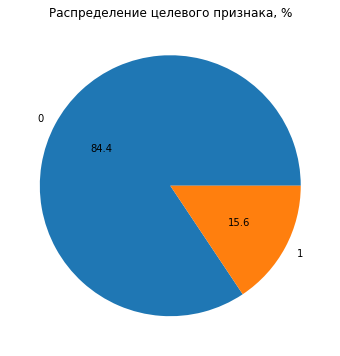

In [28]:
all_df['status'].value_counts().plot(kind='pie', title=f'Распределение целевого признака, %', autopct='%.1f', figsize=(10, 6))
plt.ylabel(None)
plt.show()

###  Корреляционный анализ

In [29]:
phik_overview = all_df.phik_matrix(interval_cols = ['MonthlyCharges', 'TotalCharges', 'contract_term'])

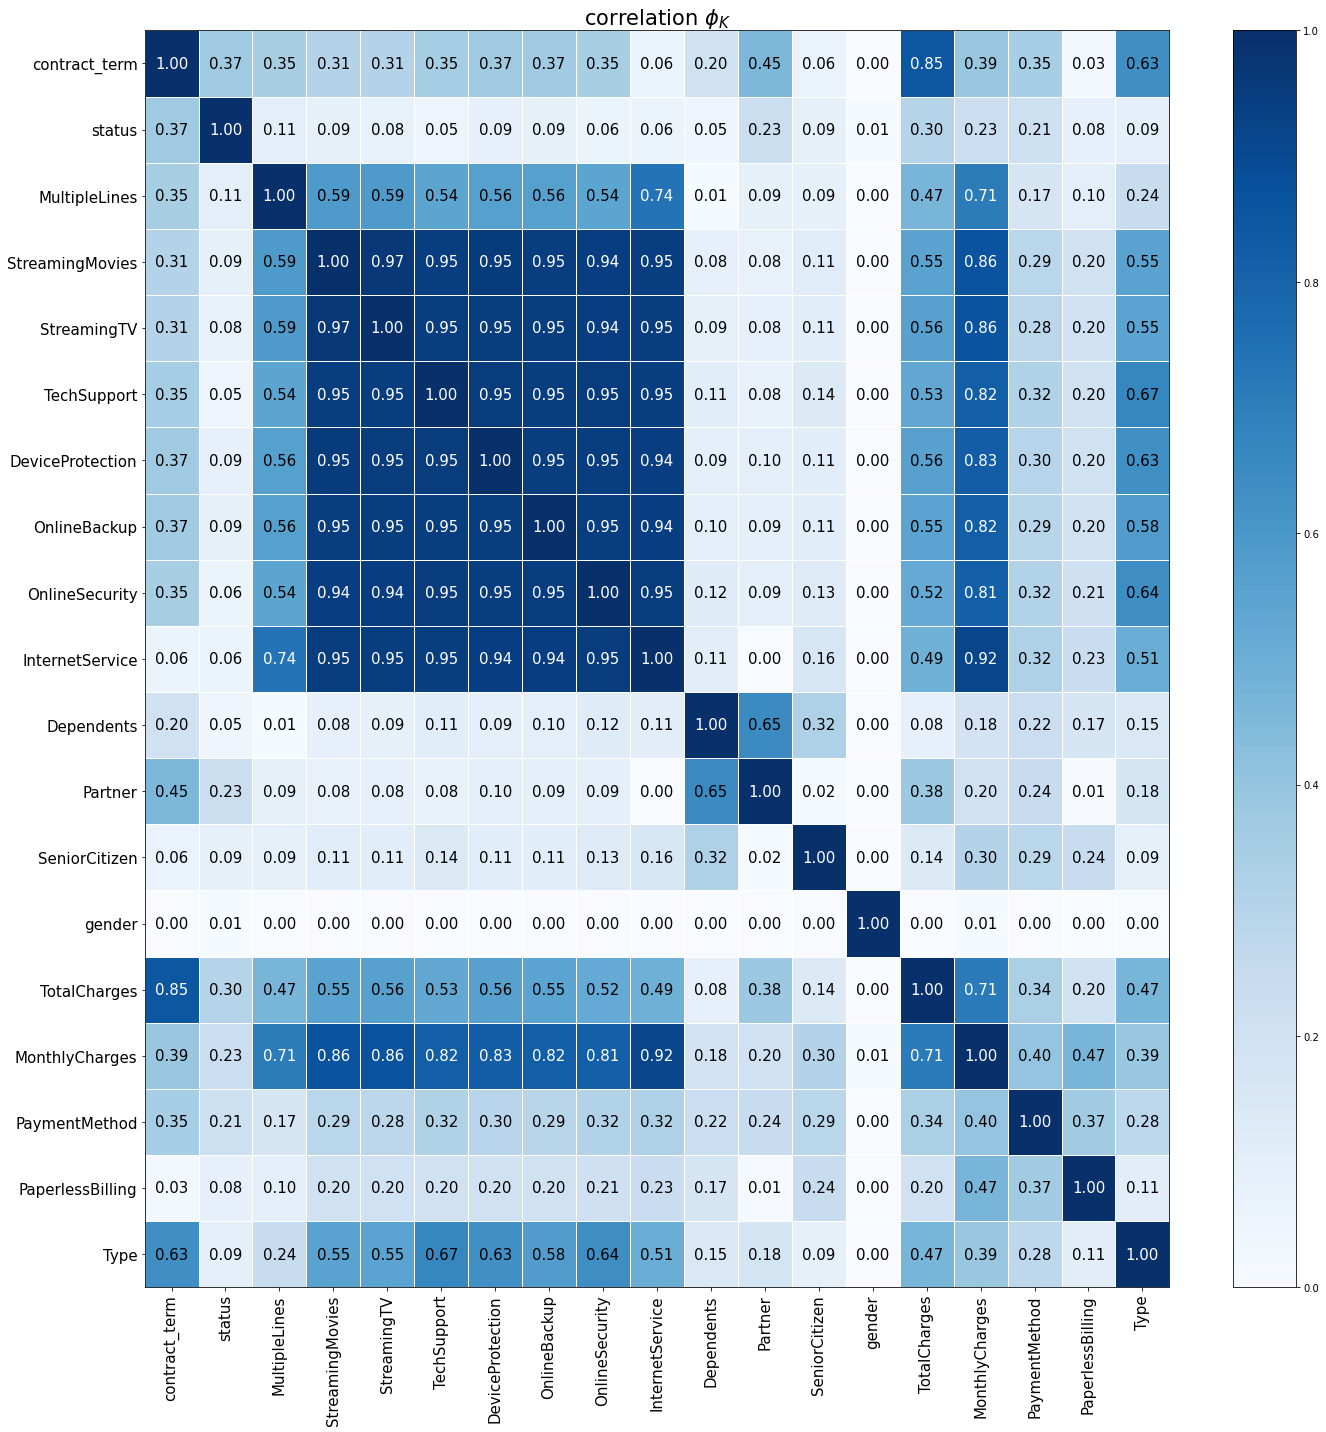

In [30]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(20, 20))

Из матрицы взаимосвязи видим, что есть высокая коллинеарность между всеми интернет услугами и признаком месячная оплата, поэтому принято решение заменить все интернет услуги на один признак - количество подключенных услуг

In [31]:
col_net_services = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
all_df['count_services'] = all_df[col_net_services].apply(lambda x: (x == 'Yes').sum(), axis=1)
all_df = all_df.drop(col_net_services, axis=1)

In [32]:
all_df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,status,contract_term,count_services
customerID,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,No package,0,31,1
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,0,1036,2
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,0,123,2
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,No package,0,1371,3
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,No,0,153,0


In [33]:
phik_overview = all_df.phik_matrix(interval_cols = ['MonthlyCharges', 'TotalCharges', 'contract_term'])

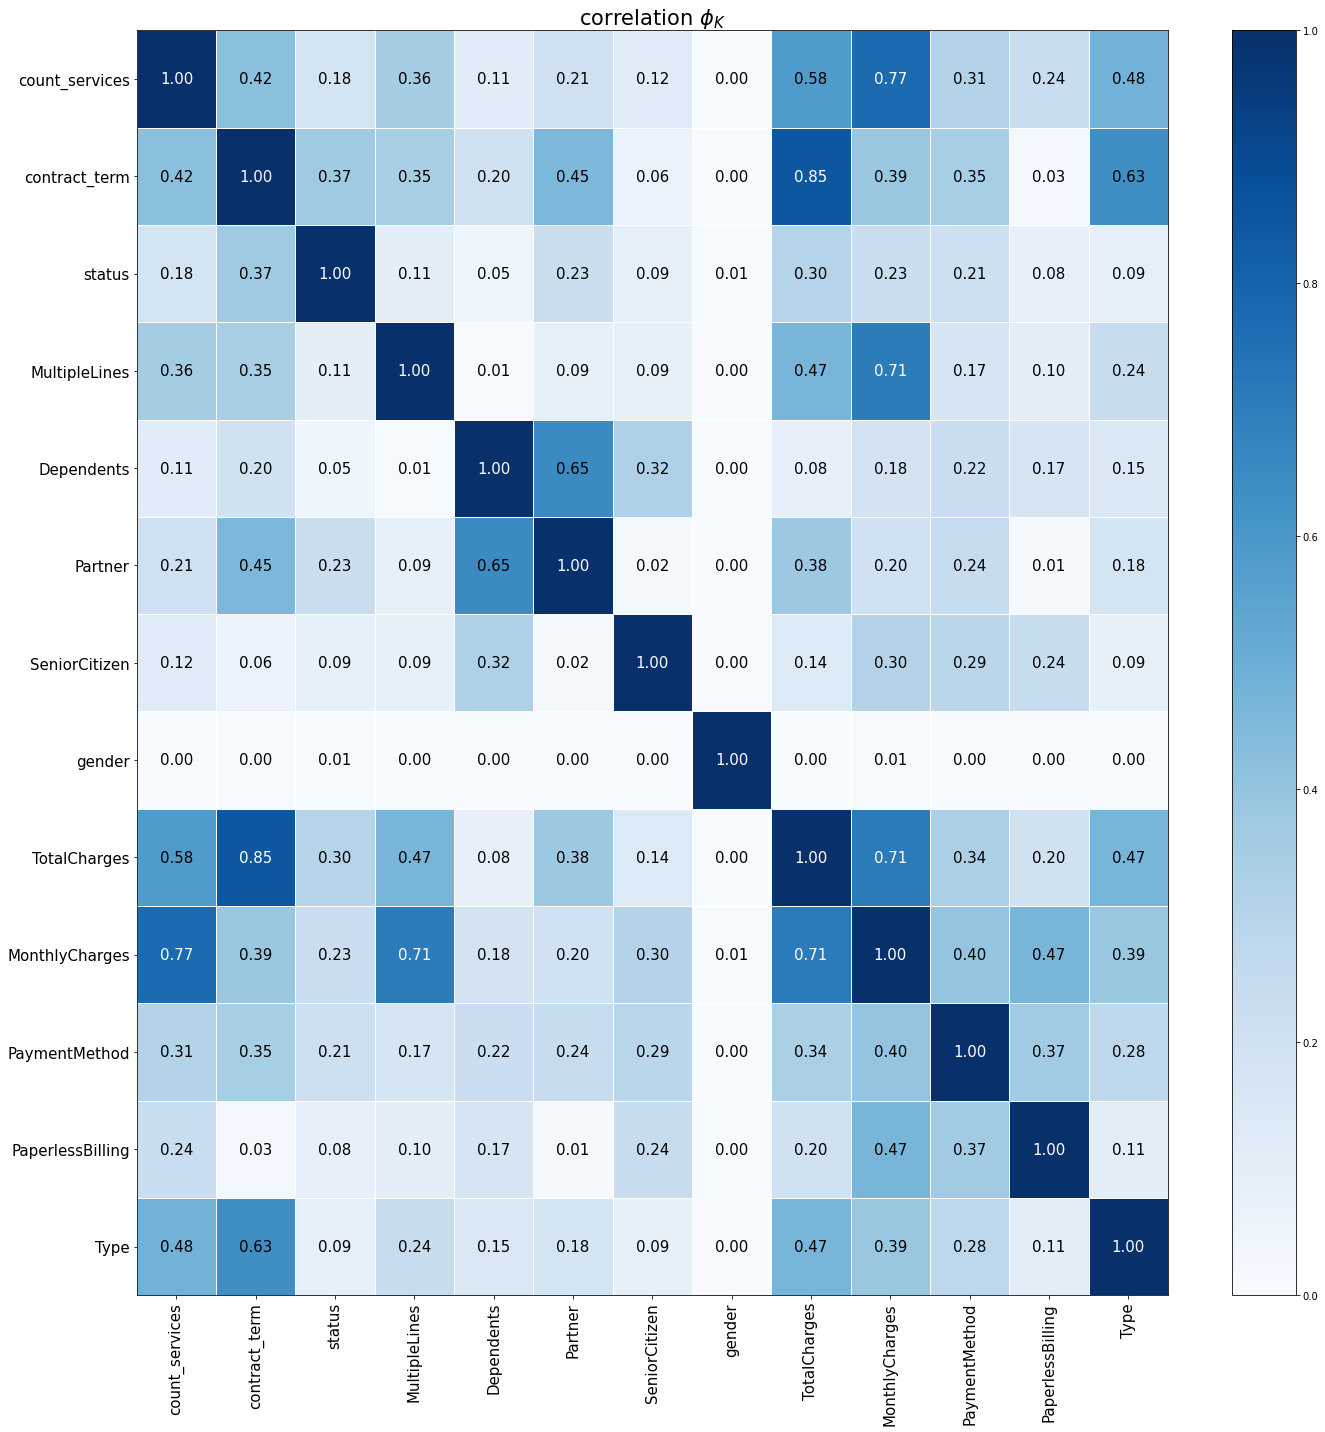

In [34]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(20, 20))

Коллинеарность полученных признаков мененьше 0.9, поэтому их оставляем

In [35]:
all_df.info()
all_df.drop('status', axis=1).describe()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   object 
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   MultipleLines     7043 non-null   object 
 10  status            7043 non-null   int64  
 11  contract_term     7043 non-null   int64  
 12  count_services    7043 non-null   int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 1.0+ MB


,MonthlyCharges,TotalCharges,contract_term,count_services
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,898.555729,2.037910
std,30.090047,2112.742814,683.130510,1.847682
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,276.000000,0.000000
50%,70.350000,1343.350000,761.000000,2.000000
75%,89.850000,3236.690000,1461.000000,3.000000
max,118.750000,9221.380000,2314.000000,6.000000


In [36]:
all_df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,status,contract_term,count_services
customerID,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,No package,0,31,1
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,0,1036,2
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,0,123,2
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,No package,0,1371,3
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,No,0,153,0


**Вывод**  
На этапе исследовательского анализа построены соответствующие графики распределения для количественных, категориальных и целевого признаков.  
Признак 'MonthlyCharges' имеет пик при маленьких расходах, далее график напоминает нормальное распределение. График признака 'TotalCharges' имеет вид распределения Пуассона, на диаграмме размаха отмечаются выбросы. Признак 'contract_term' на графике распределения имеет два пика вначале (100-200 дней) и в конце (более 2000 дней).  
Для категориальных признаков выделены следующие наблюдения:
* более половины пользователей оплачивают услуги помесячно;
* дисбаланс классов у признака 'SeniorCitizen', остальные признаки распределены без сильного перекоса в какую-либо сторону

Также есть дисбаланс у целевого признака 'status' (84.4/15.6), в работе будем использовать метрику roc-auc для оценки качества модели, она не чувствительна к дисбалансу.  
Провели корреляционный анализ данных, где выявили высокую коллинеарность между всеми интернет услугами и признаком месячная оплата. Чтобы убрать эту связь заменили все признаки интеренет услуг на один признак 'count_services' - кол-во подключенных услуг. В итоговой таблице получили 12 входных признаков и целевой.

## Подготовка данных для обучения модели

In [37]:
num_cols = ['MonthlyCharges', 'TotalCharges', 'contract_term', 'count_services']
ohe_cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines']
RANDOM_STATE = 231224
TEST_SIZE = 0.25

In [38]:
y = all_df['status']
X = all_df.drop('status', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify = y
)

In [39]:
ohe_pipe  = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [40]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)

In [41]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

**Вывод**  
На этапе подготовки данных для обучения провели разделение выборки на тренировочную и тестовую. Создали итоговый пайплайн с предобработкой и обучением. Предобработка включает в себя пайплайн для кодирования входных признаков. 

## Обучение моделей

In [42]:
param_distributions = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 12),
        'models__max_features': range(2, 12),
        'models__class_weight': [None, 'balanced']      
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': np.logspace(-2, 2, num=5),
        'models__solver': ['lbfgs', 'sag'],
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]        
    },
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE)],
        'models__iterations': [100, 200, 300, 500],
        'models__learning_rate': np.linspace(0.01, 0.3, num=5),  
        'models__depth': [4, 6, 8, 10, 12]
    }
]

In [43]:
rs = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=30
)
rs.fit(X_train, y_train)

0:	learn: 0.6351637	total: 48ms	remaining: 14.3s
1:	learn: 0.5787118	total: 53.5ms	remaining: 7.97s
2:	learn: 0.5272233	total: 72.4ms	remaining: 7.17s
3:	learn: 0.4831701	total: 86.1ms	remaining: 6.37s
4:	learn: 0.4498190	total: 100ms	remaining: 5.9s
5:	learn: 0.4256824	total: 114ms	remaining: 5.61s
6:	learn: 0.4054942	total: 128ms	remaining: 5.36s
7:	learn: 0.3916028	total: 142ms	remaining: 5.18s
8:	learn: 0.3779184	total: 156ms	remaining: 5.05s
9:	learn: 0.3649190	total: 170ms	remaining: 4.93s
10:	learn: 0.3528822	total: 185ms	remaining: 4.86s
11:	learn: 0.3432990	total: 200ms	remaining: 4.79s
12:	learn: 0.3353323	total: 214ms	remaining: 4.72s
13:	learn: 0.3301974	total: 228ms	remaining: 4.66s
14:	learn: 0.3230517	total: 243ms	remaining: 4.61s
15:	learn: 0.3161598	total: 257ms	remaining: 4.57s
16:	learn: 0.3090507	total: 272ms	remaining: 4.53s
17:	learn: 0.3041292	total: 287ms	remaining: 4.5s
18:	learn: 0.2993235	total: 302ms	remaining: 4.46s
19:	learn: 0.2957948	total: 317ms	remaini

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'gender',
                                                                                'SeniorCitizen...
                                         'models__class_weight': [None,
                                                                  'balanced'],
                                         'models__solver': ['lbfgs', 'sag'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [<catboost.core.CatBoostClassifier object at 0x7f89e2188940>],
                                         'models__depth': [4, 6, 8, 10, 12],
                                         'models__iterations': [100, 200, 300,
                                                                500],
                                         'models__learning_rate': array([0.01  , 0.0825, 0.155 , 0.2275, 0.3   ])}],
                   random_state=231224, scoring='roc_auc')

In [44]:
best_model = rs.best_estimator_
print(f'Лучшая модель:\n{best_model}\n')
print(f'Метрика roc-auc лучшей модели: {rs.best_score_}')

Лучшая модель:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod', 'gender',
                                                   'SeniorCitizen', 'Partner',
                     

Ниже представлены лучшие экземпляры всех использованных моделей в подборе параметров

In [45]:
results_df = pd.DataFrame(rs.cv_results_)

results_df['model_name'] = results_df['param_models'].apply(lambda x: type(x).__name__)
best_models = results_df.loc[results_df.groupby('model_name')['mean_test_score'].idxmax()]
best_models_summary = best_models[['model_name', 'mean_test_score', 'std_test_score',   
                                    'param_models__max_depth', 'param_models__max_features',
                                    'param_models__class_weight', 'param_models__C',
                                    'param_models__solver', 'param_models__iterations',
                                    'param_models__learning_rate', 'param_models__depth']]
# эта функция нужна чтобы None оставить, а NaN заменить на '-'
def replace_nan(x):
    if isinstance(x, float) and pd.isna(x): 
        return '-' 
    return x 

best_models_summary = best_models_summary.applymap(replace_nan)  
best_models_summary

,model_name,mean_test_score,std_test_score,param_models__max_depth,param_models__max_features,param_models__class_weight,param_models__C,param_models__solver,param_models__iterations,param_models__learning_rate,param_models__depth
8,CatBoostClassifier,0.861364,0.011223,-,-,-,-,-,300.0,0.0825,10.0
3,DecisionTreeClassifier,0.783773,0.016863,7.0,10.0,None,-,-,-,-,-
10,LogisticRegression,0.756508,0.007651,-,-,None,100.0,sag,-,-,-


In [46]:
final_predict = best_model.predict_proba(X_test)[:, 1]
final_predict_class = best_model.predict(X_test)
print(f'Метрика roc-auc на тестовой выборке: {round(roc_auc_score(y_test, final_predict), 3)}')
print(f'Метрика accuracy на тестовой выборке: {round(accuracy_score(y_test, final_predict_class), 3)}')

Метрика roc-auc на тестовой выборке: 0.865
Метрика accuracy на тестовой выборке: 0.878


In [47]:
dummy = DummyClassifier(random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
dummy_predict = dummy.predict(X_test)
print(f'Метрика roc-auc на тестовой выборке моделью, игнорирующей входные признаки: {round(roc_auc_score(y_test, dummy_predict), 3)}')
print(f'Метрика accuracy на тестовой выборке моделью, игнорирующей входные признаки: {round(accuracy_score(y_test, dummy_predict), 3)}')

Метрика roc-auc на тестовой выборке моделью, игнорирующей входные признаки: 0.5
Метрика accuracy на тестовой выборке моделью, игнорирующей входные признаки: 0.844


**Вывод**  
На этапе обучения подобрали гиперпараметры для трех моделей и с помощью рандомизированного поиска по параметрам на кросс-валидации отобрали лучшую модель по метрике roc-auc. Ей оказалсь модель градиентного бустинга CatBoostClassifier. Результат на тестовой выборке 0.865, что выше целевого. Дополнительно была посчитана метрика accuracy - 0.878. Модель правильно классифицировала 87.8% всех примеров в тестовой выборке, в комбинации со значением roc-auc можно смело сказать, что модель хорошо справляется со своей задачей. Для сравнения были посчитаны эти же метрики моделью, игнорирующей входные признаки. Результаты roc-auc = 0.5, accuracy = 0.844. При достаточно высоком значении accuracy значение roc-auc говорит нам, что сравниваемая модель не обладает никаким прогностическим потенциалом.

## Анализ модели

### Важность признаков

In [48]:
shap.initjs()
pre = best_model['preprocessor']

X_train_new = pre.transform(X_train)
X_test_new = pre.transform(X_test)
feature_names = pre.get_feature_names_out()

X_train_new = pd.DataFrame(X_train_new, columns=feature_names)
X_test_new = pd.DataFrame(X_test_new, columns=feature_names)


explainer = shap.TreeExplainer(best_model['models'], X_train_new)
shap_values = explainer(X_test_new)

 99%|===================| 1745/1761 [01:24<00:00]        

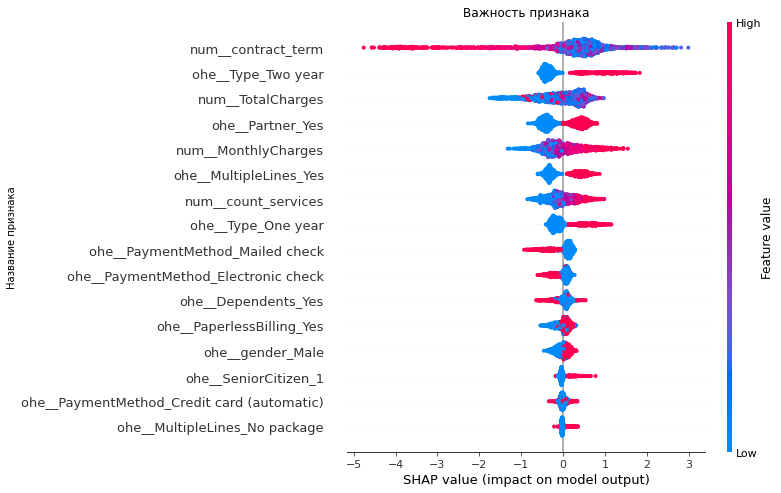

In [49]:
plt.ylabel("Название признака")
plt.title("Важность признака")
shap.plots.beeswarm(shap_values, max_display=16)

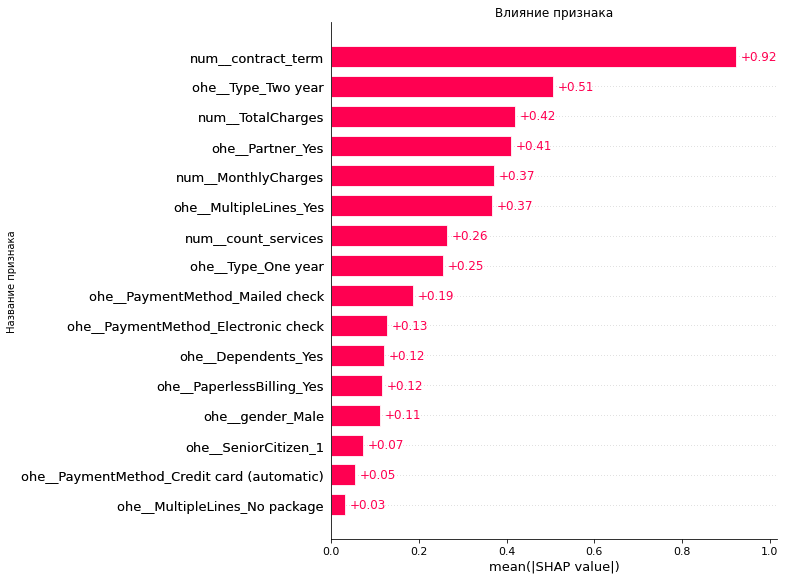

In [50]:
plt.ylabel("Название признака")
plt.title("Влияние признака")
shap.plots.bar(shap_values, max_display=16)

Важные признаки: длительность договора, тип оплаты, общие затраты  
Незначительные признаки: является ли абонент пенсионером, пол, электронный расчетный лист, есть ли у абонента дети

### Матрица ошибок

In [51]:
cm = confusion_matrix(y_test, final_predict_class)

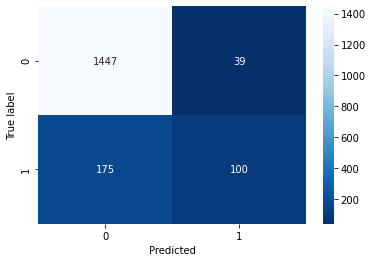

In [52]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.show()

TN = 1447: Модель правильно классифицировала 1447 случаев продления договора  
TP = 100: Модель 100 раз правильно предсказала расторжение договора  
FN = 175: Модель 175 раз ошиблась неверно предсказав продление договора  
FP = 39: Модель 39 раз ошиблась неверно предсказав расторжение договора  

В данном случае нам нужно уменьшить отток клиентов, следовательно, нужно минимизировать FN -> увеличивать метрику recall - долю из всех реальных расторжений, которую модель правильно предсказала (TP/(TP+FN)). Важно обнаружить как можно больше таких случаев. Можно позволить больше ложных срабатываний FP. Это можно реализовать настроив порог классификации.

**Вывод**  
На этапе анализа модели были найдены наиболее значимые признаки для модели: длительность договора, тип оплаты, общие затраты. Малозначимые признаки: является ли абонент пенсионером, пол, электронный расчетный лист, есть ли у абонента дети. Проведен анализ матрицы ошибок. Следует оценивать качество модели метрикой recall, а более точная настройка порога классификации позволит лучше определять случаи расторжений.

## Общий вывод

В данной выпускной работе для оператора связи «ТелеДом» была создана модель для прогноза оттока клиентов. Вся работа была поделена на этапы:  
1. На этапе загрузки данных были импортированы необходимые библиотеки, проведен первичный осмотр данных. Обработаны пустые строки в ``contract_df``, приведен к соответствующему типу данных столбец 'SeniorCitizen' в ``personal_df``.
2. На следующем подготовительном этапе объединили все таблицы в одну ``all_df``. Обработали пропущенные значения в полученном объединенном датафрейме. Создали новый признак - срок договора в днях. Извлекли из столбца 'EndDate' целевой признак 'status'.
3. На этапе исследовательского анализа построены соответствующие графики распределения для количественных, категориальных и целевого признаков. Признак 'MonthlyCharges' имеет пик при маленьких расходах, далее график напоминает нормальное распределение. График признака 'TotalCharges' имеет вид распределения Пуассона, на диаграмме размаха отмечаются выбросы. Признак 'contract_term' на графике распределения имеет два пика вначале (100-200 дней) и в конце (более 2000 дней).
Для категориальных признаков выделены следующие наблюдения:
    * более половины пользователей оплачивают услуги помесячно;
    * дисбаланс классов у признака 'SeniorCitizen', остальные признаки распределены без сильного перекоса в какую-либо сторону
    
 Также есть дисбаланс у целевого признака 'status' (84.4/15.6), в работе будем использовать метрику roc-auc для оценки качества модели, она не чувствительна к дисбалансу.  
 Провели корреляционный анализ данных, где выявили высокую коллинеарность между всеми интернет услугами и признаком месячная оплата. Чтобы убрать эту связь заменили все признаки интеренет услуг на один признак 'count_services' - кол-во подключенных услуг. В итоговой таблице получили 12 входных признаков и целевой.  
4. На этапе подготовки данных для обучения провели разделение выборки на тренировочную и тестовую. Создали итоговый пайплайн с предобработкой и обучением. Предобработка включает в себя пайплайн для кодирования входных признаков. 
5. На этапе обучения подобрали гиперпараметры для трех моделей и с помощью рандомизированного поиска по параметрам на кросс-валидации отобрали лучшую модель по метрике roc-auc. Ей оказалсь модель градиентного бустинга CatBoostClassifier. Реузальтат на тестовой выборке 0.865, что выше целевого. Дополнительно была посчитана метрика accuracy - 0.878. Модель правильно классифицировала 87.8% всех примеров в тестовой выборке, в комбинации со значением roc-auc можно смело сказать, что модель хорошо справляется со своей задачей. Для сравнения были посчитаны эти же метрики моделью, игнорирующей входные признаки. Результаты roc-auc = 0.5, accuracy = 0.844. При достаточно высоком значении accuracy значение roc-auc говорит нам, что сравниваемая модель не обладает никаким прогностическим потенциалом.
6. На этапе анализа модели были найдены наиболее значимые признаки для модели: длительность договора, тип оплаты, общие затраты. Малозначимые признаки: является ли абонент пенсионером, пол, электронный расчетный лист, есть ли у абонента дети. Проведен анализ матрицы ошибок. Следует оценивать качество модели метрикой recall, а более точная настройка порога классификации позволит лучше определять случаи расторжений.

Рекомендации для бизнеса:
* обратить внимание на длительность договора, чем больший срок договора, тем вероятнее, что абонент его не расторгнет;
* составлять договор с оплатой раз в 2 года;
* стоит рассмотреть дополнительно метрику recall для оценки качества модели